In [101]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np

In [102]:
 # Setting display options to show all columns without truncation
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [107]:
def read_merge_prepare_data(forecast_period, Macro_Data):
    # Read CSV files
    forecast_file_path = f"data/processed_data/{forecast_period}.csv"
    df = pd.read_csv(forecast_file_path)


    # Merge DataFrames on Dates and drop unnecessary columns
    Merged_Data = pd.merge(df, Macro_Data[['GDP_log_return', 'Cons_log_return', 'IPT_log_return', 'Unempl', 'Dates']],
                           right_on='Dates', left_on='rankdate').drop('Dates', axis=1)

    Merged_Data['Date'] = pd.to_datetime(Merged_Data['rankdate'], format='%Y-%m').dt.to_period('M')
    Merged_Data = Merged_Data[(Merged_Data['Date'].dt.year >= 1985) & (Merged_Data['Date'].dt.year <= 2019)].drop(['rankdate'], axis=1)

    # Preparing the datasets
    Merged_Data.sort_values(by='Date', ascending=True, inplace=True)

    # Columns to drop
    columns_to_drop = ['cfacshr', 'Unnamed: 0', 'ticker', 'cusip', 'cname', 'fpedats', 'statpers', 'anndats_act', 'fpi', 'actual', 'meanest']
    Merged_Data.drop(columns=columns_to_drop, axis=1, inplace=True)

    # Missing values per column
    missing_values = Merged_Data.isna().sum()
    print(f"{forecast_period} Missing Values:")
    print(missing_values[missing_values > 0])

    # Drop rows with missing values 
    Merged_Data.dropna(axis=0, inplace=True)

    print(f' len extreme data droped {len(Merged_Data.loc[abs(Merged_Data.adj_actual) > 10])}')
    Merged_Data = Merged_Data.loc[abs(Merged_Data['adj_actual']) < 10]
    print(f'len data {len(Merged_Data)}')

    return Merged_Data


In [108]:
macro_file_path = "data/processed_data/macro_data.csv"
Macro_Data = pd.read_csv(macro_file_path)

periods = ['Q1', 'Q2', 'Q3', 'A1', 'A2']
# Create an empty dictionary to store DataFrames
forecast_data = {}

# Read CSV files into DataFrames and store them in the dictionary
for forecast in periods:
    forecast_data[forecast] = read_merge_prepare_data(forecast, Macro_Data)


Q1 Missing Values:
price     9
ret      44
dtype: int64
 len extreme data droped 1550
len data 940976
Q2 Missing Values:
price     9
ret      41
dtype: int64
 len extreme data droped 1293
len data 856410
Q3 Missing Values:
price     9
ret      35
dtype: int64
 len extreme data droped 1101
len data 785711
A1 Missing Values:
price    13
ret      50
dtype: int64
 len extreme data droped 9639
len data 988378
A2 Missing Values:
price     7
ret      36
dtype: int64
 len extreme data droped 9878
len data 841323


def train_test_random_forest(period, data_frame):
    # Filter data for training and testing based on date (train on 1988, test after; except A2, train on 2 years)
    if period=='A2':
        start_test='1987-01'
    else:
        start_test='1986-01'
    train_data = data_frame[data_frame['Date'] < start_test]
    test_data = data_frame[data_frame['Date'] >= start_test]

    # Separate predictors and target variable
    y_train = train_data['adj_actual']
    X_train_full = train_data.loc[:, ~train_data.columns.isin(['adj_actual'])]

    y_test = test_data['adj_actual']
    X_test_full = test_data.loc[:, ~test_data.columns.isin(['adj_actual'])]

    X_train = X_train_full.drop(['Date', 'permno'], axis=1)
    X_test = X_test_full.drop(['Date', 'permno'], axis=1)

    #random forest paramters  !! need gridsearch
    sample_fractions = {
    'A2': 0.15,
    'A1': 0.6,
    'Q1': 0.6,
    'Q2': 0.02,
    'Q3': 0.02,
}

    # Instantiate a RandomForestRegressor 
    forest_model_rf = RandomForestRegressor(n_estimators=2000, max_depth=7,max_samples=0.01, min_samples_leaf=5,  n_jobs=-1) #max_samples=sample_fractions[period]
    print("Training Random Forest")
    forest_model_rf.fit(X_train, y_train)
    print("Random Forest training completed")

    y_hat_train = forest_model_rf.predict(X_train)
    y_hat_test = forest_model_rf.predict(X_test)

    # Dataframe with permno, date, predictor, and predicted value
    result_df = X_test_full.copy()
    result_df['adj_actual'] = y_test
    result_df['predicted_adj_actual'] = y_hat_test

    print(r2_score(result_df.adj_actual, result_df.predicted_adj_actual))

    result_df['biased_expectation'] = (result_df.adj_meanest - result_df.predicted_adj_actual) / result_df.price
    result_df['biased_expectation'].describe()

    return result_df



The paper actually does training in rolling windo of size 12 months. indeed in previous case the model is not able to rpeidct valeus outside a thin range as the 1985 dtaat are enclosed in a subrange on the possible values between 1986 and 2019.

# Rolling window

In [109]:
def train_test_random_forest_rolling(period, data_frame):
    # Filter data for training and testing based on date (train on 1988, test after; except A2, train on 2 years)
    data_frame[(data_frame['Date']>= '1985-01') & (data_frame['Date']<= '2019-12' )]
    start_train=pd.to_datetime('1985-01', format='%Y-%m').to_period('M')
    y_hat_test = pd.Series()
    y_test_all = pd.Series()
    length_train = 11 # 12 months, hence add 11 to first month 
    n_loops = 408
    if period == 'A2':
        length_train = 23 # 24 months 
        n_loops = 396

    for i in range(0, n_loops): # till 12-2019 420 months; last for loop 420-12= 408, for A2 = 420-24=396
        train_start_date = (start_train.to_timestamp() + pd.DateOffset(months=i)).to_period('M')
        train_end_date = (start_train.to_timestamp() + pd.DateOffset(months=length_train+i)).to_period('M')
        train_data = data_frame[(data_frame['Date'] >= train_start_date) & (data_frame['Date'] <= train_end_date)]
        print(f'train btw {train_start_date} and {train_end_date}')

        test_date = (start_train.to_timestamp() + pd.DateOffset(months=length_train + 1 + i)).to_period('M')
        test_data = data_frame[data_frame['Date'] == test_date]
        print(f'test on {test_date}')

        if len(test_data)!=0:
            print(period)
            print(f'test data length {len(test_data)}')
            # Separate predictors and target variable
            y_train = train_data['adj_actual']
            X_train_full = train_data.loc[:, ~train_data.columns.isin(['adj_actual'])]

            y_test = test_data['adj_actual']
            X_test_full = test_data.loc[:, ~test_data.columns.isin(['adj_actual'])]

            X_train = X_train_full.drop(['Date', 'permno'], axis=1)
            X_test = X_test_full.drop(['Date', 'permno'], axis=1)
            print(f' min y train {y_train.min()}')
            print(f' max y train {y_train.max()}')
            # Instantiate a RandomForestRegressor 
            forest_model_rf = RandomForestRegressor(n_estimators=2000, max_depth=7, max_samples=0.01,  min_samples_leaf=5,  n_jobs=-1) #max_samples=sample_fractions[period]
            print("Training Random Forest")
            forest_model_rf.fit(X_train, y_train)
            print("Random Forest training completed")

            y_hat_test = pd.concat([y_hat_test, pd.Series(forest_model_rf.predict(X_test))])
            print(f' len prediciton {len(y_hat_test.values)}')

    # Dataframe with permno, date, predictor, real value and predicted value
    result_df = pd.DataFrame(data_frame[(data_frame['Date']>= '1986-01') & (data_frame['Date']<= '2019-12') ])
    if period == 'A2':
        result_df = pd.DataFrame(data_frame[(data_frame['Date']>= '1987-01') & (data_frame['Date']<= '2019-12') ])
    result_df['predicted_adj_actual'] = y_hat_test.values

    result_df['biased_expectation'] = (result_df.adj_meanest - result_df.predicted_adj_actual) / result_df.price

    return result_df



In [ ]:
results_rolling = {}

# 18 min Q1 with 1% sample
for forecast, df in forecast_data.items():
    print(forecast)
    results_rolling[forecast] = train_test_random_forest_rolling(forecast, df)

In [111]:
for period, df in results_rolling.items():
    df.to_csv(f"results/{period}_rf.csv", index=False)

 bias for Q1  = 0.004227585140887522
 bias for Q2  = 0.00649487515203533
 bias for Q3  = 0.006435535946531196
 bias for A1  = 0.021176346363500843
 bias for A2  = 0.029962655681147934


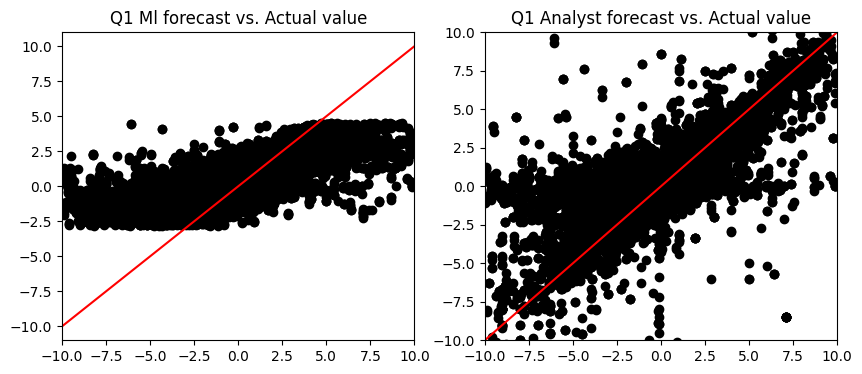

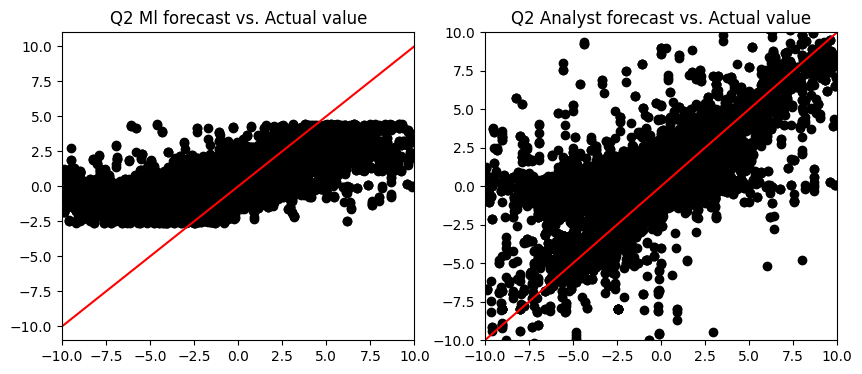

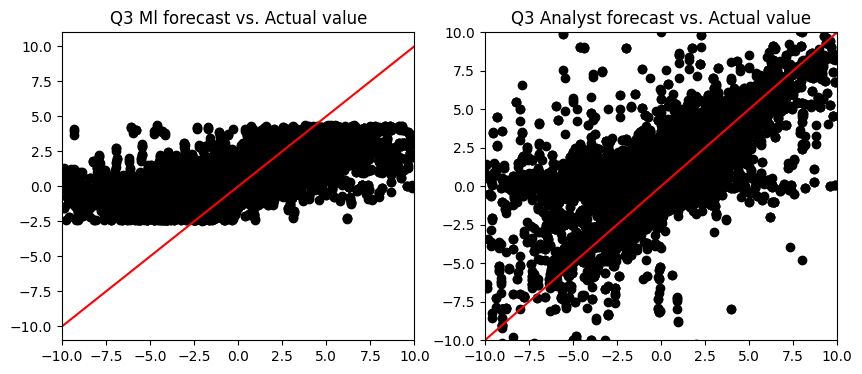

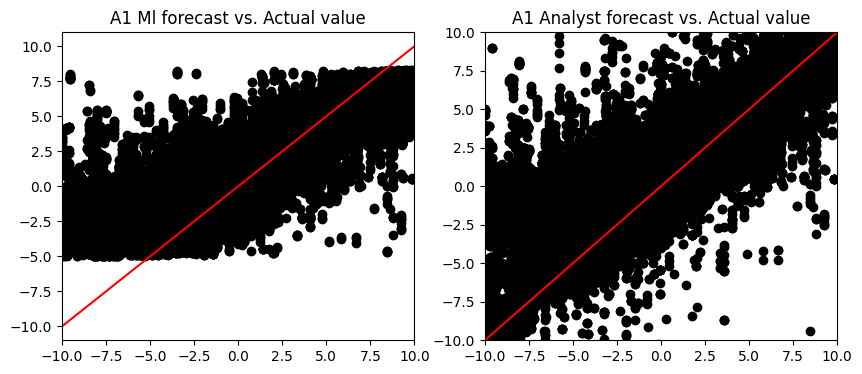

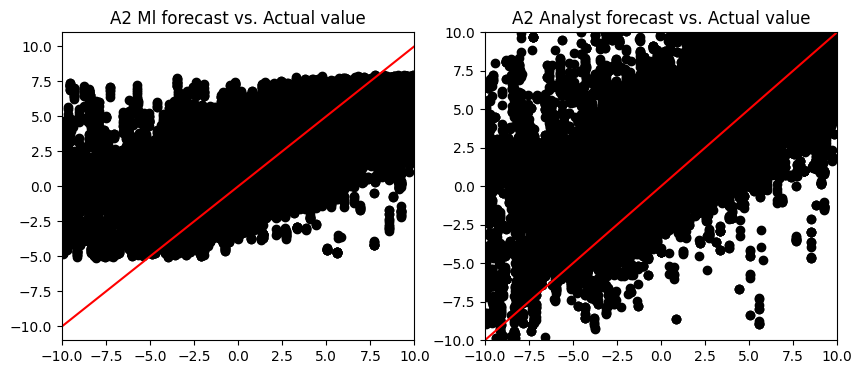

In [141]:
for period in periods:
    fig, ax = plt.subplots(1,2, figsize=(10, 4))
    ax[0].plot(results_rolling[period].adj_actual, results_rolling[period].predicted_adj_actual, 'o', color='black')
    ax[0].plot([-10, 10], [-10, 10], 'r-')
    ax[0].set_title(f'{period} Ml forecast vs. Actual value')
    ax[0].set_xlim(-10,10)
    #ax[0].set_ylim(-10,10)



    print(f' bias for {period}  = {results_rolling[period].biased_expectation.mean()}')

    # plot forecast and exact 
    ax[1].plot(results_rolling[period].adj_actual, results_rolling[period].adj_meanest, 'o', color='black')
    ax[1].plot([-10,10], [-10,10], 'r-')
    ax[1].set_title(f'{period} Analyst forecast vs. Actual value')
    ax[1].set_xlim(-10,10)
    ax[1].set_ylim(-10,10)


   

Note problems in rf: values cut !!!!!!! check if beacosue values 

930584
 r2_score ml is 0.010175267187310322
 r2_score analyst  is 0.8256414174946995
845931
 r2_score ml is 0.004448861853374231
 r2_score analyst  is 0.7494324490857546
776832
 r2_score ml is 0.0011557487710700531
 r2_score analyst  is -0.16904041897800082
982282
 r2_score ml is 0.0231656207874541
 r2_score analyst  is 0.8214259794718104
824229
 r2_score ml is 0.019808289682403557
 r2_score analyst  is -1.2540734589200961


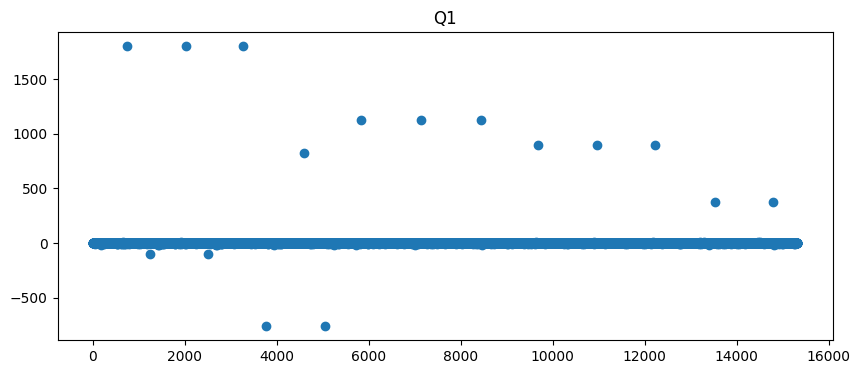

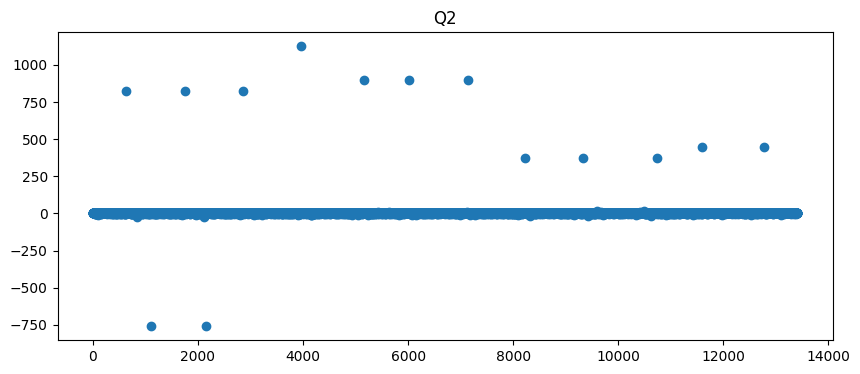

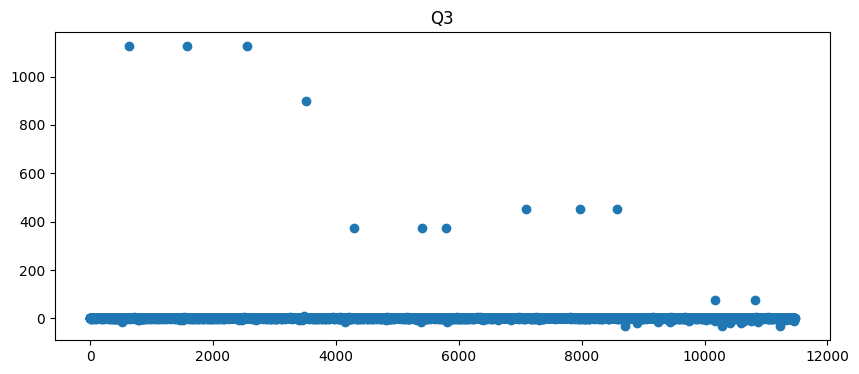

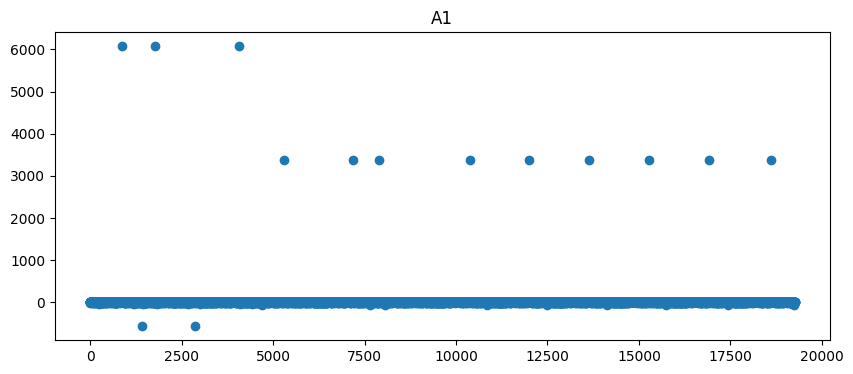

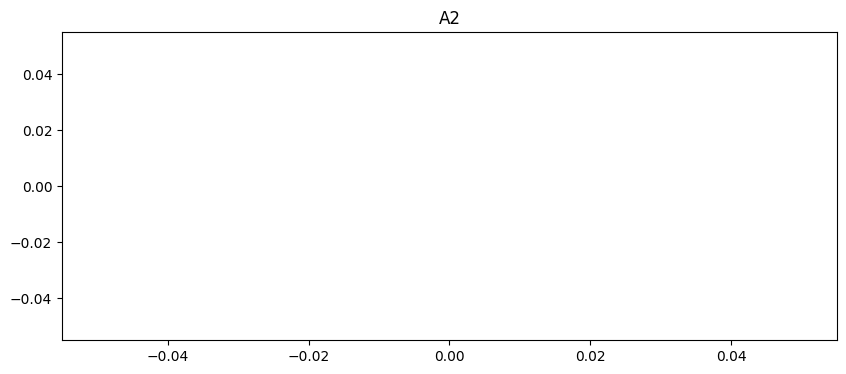

In [137]:
for period, df in results_rolling.items():
    fig, ax = plt.subplots(1,1, figsize=(10, 4))
    plt.scatter(range(len(df[df.Date < '1987-01'].adj_actual)),df[df.Date < '1987-01'].adj_actual)
    plt.title(period)
    print(len(df))
    print(f' r2_score ml is {r2_score(df.adj_actual, df.predicted_adj_actual)}')
    print(f' r2_score analyst  is {r2_score(df.adj_actual, df.adj_meanest)}')

